# Intro
The Hand Gesture Recognition Database is a collection of near-infra-red images of ten distinct hand gestures. In this notebook we use end-to-end deep learning to build a classifier for these images.

We'll first load some packages required for reading in and plotting the images. 

In [1]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting


As described in the Data Overview, there are 10 folders labelled 00 to 09, each containing images from a given subject. In each folder there are subfolders for each gesture. We'll build a dictionary `lookup` storing the names of the gestures we need to identify, and giving each gesture a numerical identifier. We'll also build a dictionary `reverselookup` that tells us what gesture is associated to a given identifier.

In [2]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('../input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 8,
 '02_l': 0,
 '03_fist': 9,
 '04_fist_moved': 1,
 '05_thumb': 7,
 '06_index': 4,
 '07_ok': 6,
 '08_palm_moved': 5,
 '09_c': 2,
 '10_down': 3}

Next we read in the images, storing them in `x_data`. We store the numerical classifier for each image in `y_data`. Since the images are quite large and are coming from an infra-red sensor, there's nothing really lost in converting them to greyscale and resizing to speed up the computations.

In [3]:
x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('../input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('../input/leapgestrecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((320, 120))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

Let's take a look at some of the pictures. Since each of the subfolders in `00` contained 200 images, we'll use the following piece of code to load one image of each gesture.

The first thing to note is that this is not a difficult classification problem. The gestures are quite distinct, the images are clear, and there's no background whatsoever to worry about. If you weren't comfortable with deep learning, you could do quite well with some straight-forward feature detection -- for example the '07_ok' class could easily be detected with binary thresholding followed by circle detection. 

Moreover, the gestures consistently occupy only about 25% of the image, and all would fit snugly inside a square bounding box. Again if you're looking to do basic feature detection, an easy first step would be to write a short script cropping everything to the relevant 120 x 120 square. 

But the point of this notebook is to show how effective it is to just throw a neural network at a problem like this without having to worry about any of the above, so that's what we're going to do. 

At the moment our vector `y_data` has shape `(datacount, 1)`, with `y_data[i,0] = j` if the `i`th image in our dataset is of gesture `reverselookup[j]`. In order to convert it to one-hot format, we use the keras function to_categorical:

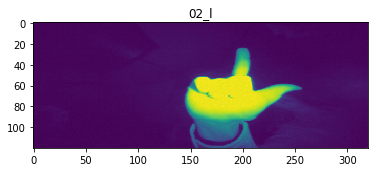

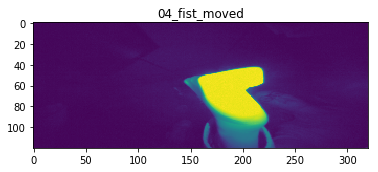

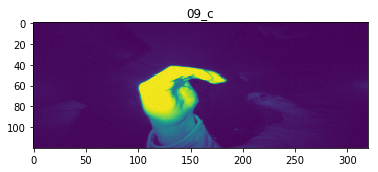

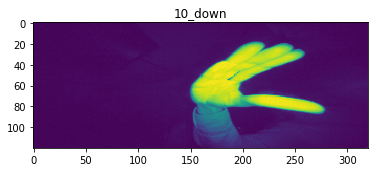

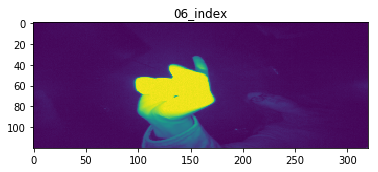

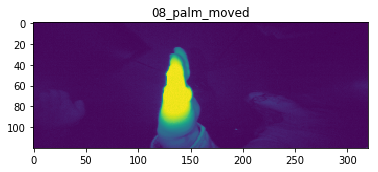

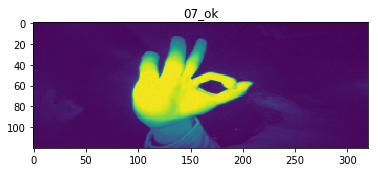

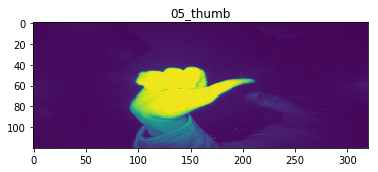

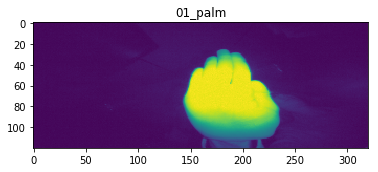

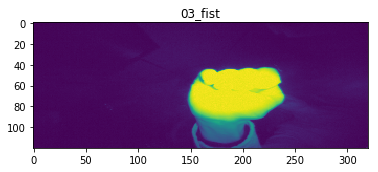

In [4]:
from random import randint
for i in range(0, 10):
    plt.imshow(x_data[i*200 , :, :])
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()

In [5]:
import keras
from keras.utils import to_categorical
y_data = to_categorical(y_data)


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Our set of images has shape `(datacount, 120, 320)`. Keras will be expecting another slot to tell it the number of channels, so we reshape `x_data` accordingly. We also rescale the values in `x_data` to lie between 0 and 1.

In [6]:
x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

We need a cross-validation set and a test set, and we'll use the `sklearn` package to construct these. In order to get an 80-10-10 split, we call `train_test_split` twice, first to split 80-20, then to split the smaller chunk 50-50. Note that we do this after the rescaling step above, to ensure that our train and test sets are coming from the same distribution.

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)

Now it's time to build our network. We'll use keras.

In [8]:
from keras import layers
from keras import models

Since our images are big (we chose not to do any cropping) and the classification problem looks quite easy, we're going to downsample fairly aggressively, beginning with a 5 x 5 filter with a stride of 2. Note we have to specify the correct input shape at this initial layer, and keras will figure it out from then on. We won't worry about padding since it's clear that all the useful features are well inside the image. We'll continue with a sequence of convolutional layers followed by max-pooling until we arrive at a small enough image that we can add a fully-connected layer. Since we need to classify between 10 possibilities, we finish with a softmax layer with 10 neurons. 

In [9]:
model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320,1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Finally, we fit the model.

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size=128, verbose=1, validation_data=(x_validate, y_validate))

Train on 16000 samples, validate on 2000 samples
Epoch 1/2
16000/16000 [==============================] - 261s 16ms/step - loss: 0.4252 - acc: 0.8604 - val_loss: 0.0214 - val_acc: 0.9960
Epoch 2/2
16000/16000 [==============================] - 263s 16ms/step - loss: 0.0136 - acc: 0.9968 - val_loss: 0.0065 - val_acc: 0.9990


At this point we would typically graph the accuracy of our model on the validation set, and choose a suitable number of epochs to train for to avoid overfitting. We might also consider introducing dropout and regularisation. However, we can see we're getting perfect accuracy on the validation set after just one or two epochs, so we're pretty much done. Let's quickly confirm that this is carrying through to the test set:

In [11]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

2000/2000 [==============================] - 12s 6ms/step
Accuracy:0.9995


You'll get slightly different numbers each time you run it but you should be getting between 99.9 and 100% accuracy. Great!

In [25]:
rest= model.predict(np.array([x_test[1]]))


7


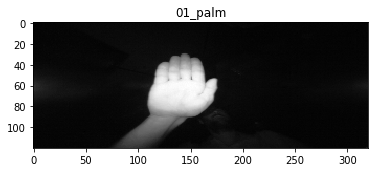

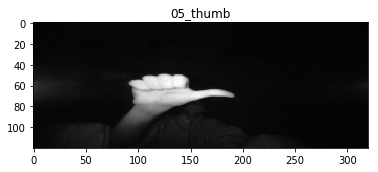

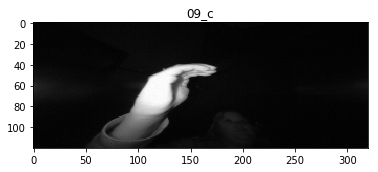

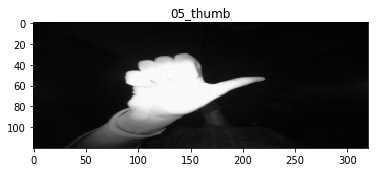

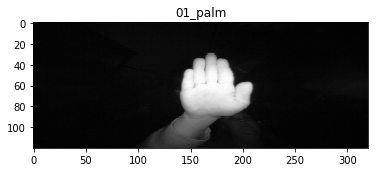

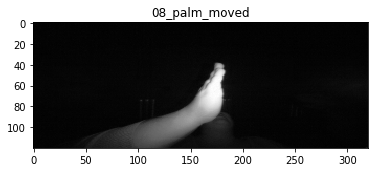

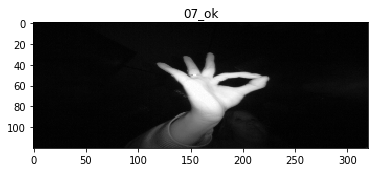

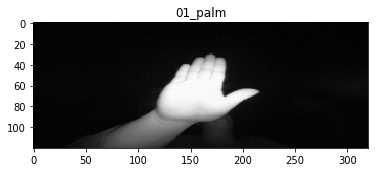

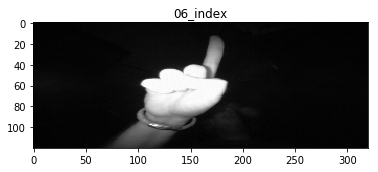

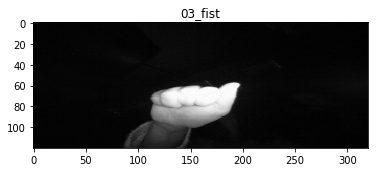

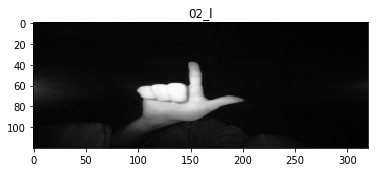

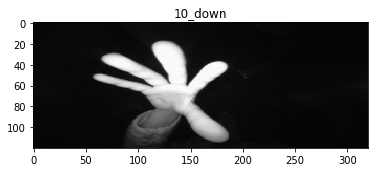

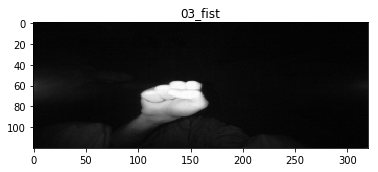

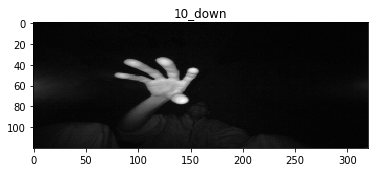

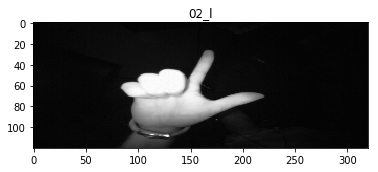

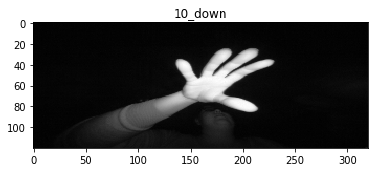

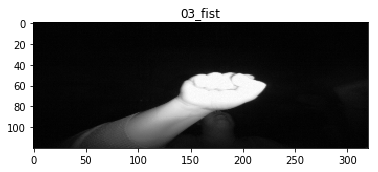

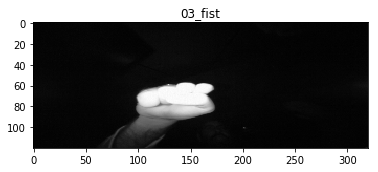

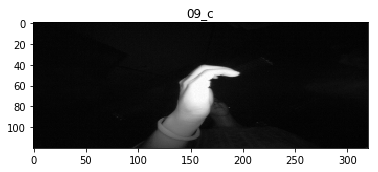

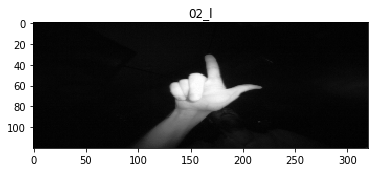

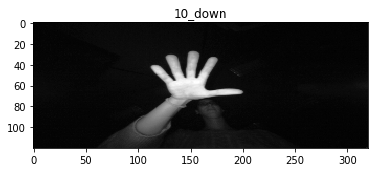

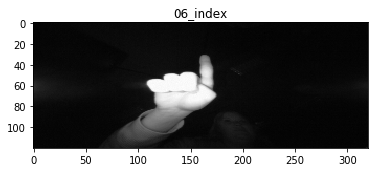

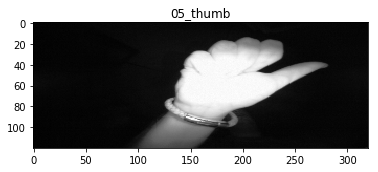

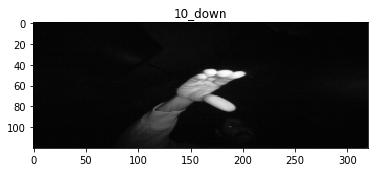

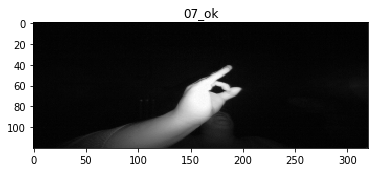

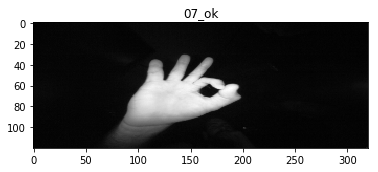

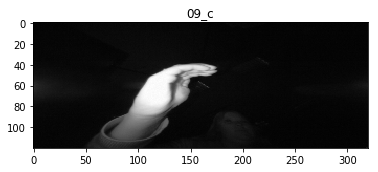

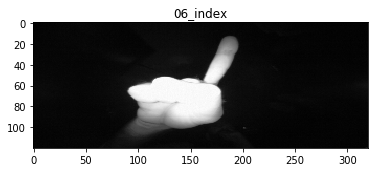

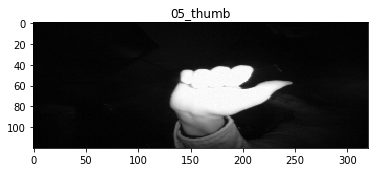

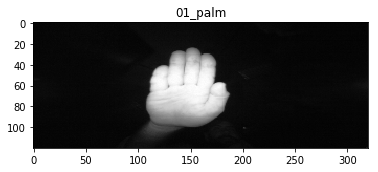

In [39]:
for i in range(0,30):
    rest= model.predict(np.array([x_test[i]]))
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(reverselookup[np.argmax(rest)])
    plt.show()

{'02_l': 0, '04_fist_moved': 1, '09_c': 2, '10_down': 3, '06_index': 4, '08_palm_moved': 5, '07_ok': 6, '05_thumb': 7, '01_palm': 8, '03_fist': 9}
{0: '02_l', 1: '04_fist_moved', 2: '09_c', 3: '10_down', 4: '06_index', 5: '08_palm_moved', 6: '07_ok', 7: '05_thumb', 8: '01_palm', 9: '03_fist'}
